# Housekeeping

The following code will allow you to load and installt all required packages, libraries and functions in order to run the code in the notebook. If a package is not installed on your computer, a line of code is provided as a comment that can be used to install the package with via the command prompts of Conda. IMPORTANT: in order to see all of the plots created in this notebook, please ensure to trust this notebook by going to File -> Trust Notebook.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pycountry # to install run conda install -c conda-forge pycountry
import json
import folium
from tld import get_tld
from datetime import date

from matplotlib.ticker import StrMethodFormatter
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['text.color'] = 'black'
from matplotlib import style
style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

# Data prep and engineering

This first section is all about preparing the data and data engineering. This will be used in the notebooks for both questions.

## Organisations

First, we will read and transform data on the organizations sheet.

In [3]:
# Read initial csv
dforg = pd.read_csv('_data/organisations.csv')

In [4]:
# Remove all rows with NA values in funding_total_usd
dforg = dforg[dforg['funding_total_usd'].notna()]

In [5]:
# Change na values to 'unknown', blanks or 'NAN'. 
dforg['state_code'] = dforg['state_code'].fillna('')
dforg[['name','category_list','market','status','homepage_url']] = dforg[['name','category_list','market','status','homepage_url']].fillna('Unknown')

# Add all necessary new columns such as: timestamp breakdown of founding, first and last funding date
dforg['founding_year']=pd.to_datetime(dforg['founded_at'], errors='coerce').dt.year.astype(int, errors='ignore')
dforg['founding_month']=pd.to_datetime(dforg['founded_at'], errors='coerce').dt.month.astype(int, errors='ignore')
dforg['founding_quarter']=pd.to_datetime(dforg['founded_at'], errors='coerce').dt.quarter.astype(int, errors='ignore')
dforg['founding_day']=pd.to_datetime(dforg['founded_at'], errors='coerce').dt.day.astype(int, errors='ignore')
dforg['first_funding_year']=pd.to_datetime(dforg['first_funding_at'], errors='coerce').dt.year.astype(int, errors='ignore')
dforg['first_funding_month']=pd.to_datetime(dforg['first_funding_at'], errors='coerce').dt.month.astype(int, errors='ignore')
dforg['first_funding_quarter']=pd.to_datetime(dforg['first_funding_at'], errors='coerce').dt.quarter.astype(int, errors='ignore')
dforg['first_funding_day']=pd.to_datetime(dforg['first_funding_at'], errors='coerce').dt.day.astype(int, errors='ignore')
dforg['last_funding_year']=pd.to_datetime(dforg['last_funding_at'], errors='coerce').dt.year.astype(int, errors='ignore')
dforg['last_funding_month']=pd.to_datetime(dforg['last_funding_at'], errors='coerce').dt.month.astype(int, errors='ignore')
dforg['last_funding_quarter']=pd.to_datetime(dforg['last_funding_at'], errors='coerce').dt.quarter.astype(int, errors='ignore')
dforg['last_funding_day']=pd.to_datetime(dforg['last_funding_at'], errors='coerce').dt.day.astype(int, errors='ignore')

# Create columns for days between first and last funding, and days between founding and last funding, and drop columns.
dforg['DaysBetweenFunding'] = pd.to_datetime(dforg['last_funding_at']) - pd.to_datetime(dforg['first_funding_at'])
dforg['DaysBetweenFoundFund'] = pd.to_datetime(dforg['last_funding_at']) - pd.to_datetime(dforg['founded_at'])

#Change column type to just the number of days
dforg['DaysBetweenFunding']=dforg['DaysBetweenFunding']/np.timedelta64(1, 'D')
dforg['DaysBetweenFoundFund']=dforg['DaysBetweenFoundFund']/np.timedelta64(1, 'D')

# Remove spaces before and after values
dforg.rename(columns=lambda x: x.strip(), inplace=True)

# Calculate average days between funding rounds
dforg['DaysPerRound'] = dforg['DaysBetweenFunding'] / dforg['funding_rounds']

In [6]:
# Remove all entries with founding year before 1995
dforg = dforg[dforg['founding_year'] >= 1995]

In [7]:
# There are 8 problematic websites in the data with incorrect Top-Level Domains, commas where there should
# be dots or incomplete website URLs. We replace these values by the corrected website data
dforg['homepage_url'] = dforg['homepage_url'].replace('http://www.huddleapp,me', 'http://www.huddleapp.me')
dforg['homepage_url'] = dforg['homepage_url'].replace('http://www.benjerry/jacklondonsquare.com', 'http://www.benjerryjacklondonsquare.com')
dforg['homepage_url'] = dforg['homepage_url'].replace('http://www.miew.co.hp', 'http://www.miew.co.jp')
dforg['homepage_url'] = dforg['homepage_url'].replace('http://www.nomadicabrainstorming.como', 'http://www.nomadicabrainstorming.com')
dforg['homepage_url'] = dforg['homepage_url'].replace('http://www.sparkow', 'http://www.sparkow.fr')
dforg['homepage_url'] = dforg['homepage_url'].replace('http://www.secneo.com http://www.bangcle.com', 'http://www.bangcle.com')
dforg['homepage_url'] = dforg['homepage_url'].replace('http://Sparo Labs is bringing the power of modern technology to the world of asthma.', 'https://sparohealth.com/')
dforg['homepage_url'] = dforg['homepage_url'].replace('http://translate.googleusercontent.com/translate_c?hl=de&ie=UTF-8&sl=de&tl=en&u=http://www.spiegel.de/wirtschaft/unternehmen/0,1518,754461,00.html&prev=_t&rurl=translate.google.de&twu=1&usg=ALkJrhgA_p5iyssKyL0mm4sr4fMnnQ9yyw', 'http://www.safe-id.de/')

In [8]:
# Defining an empty list to fill with the domain function objects
urls = []

# for every URL in the original dataframe, we extract the top-level domain information as an object 
# and ignore errors as the errors should only be for values that list 'Unknown'
for i in dforg['homepage_url']:
     urls.append(get_tld(i, as_object=True, fail_silently=True))
        
# Changing data type from object to string and populate new column
dforg['Domains'] = [str(i) for i in urls]

# We repeat the same process but now focus on the length of the names that companies use for their websites
names = []
for j in dforg['homepage_url']:  
     names.append(get_tld(j, as_object=True, fail_silently=True))
names = [j.domain if j != None else j for j in names]

# As the unknown values cannot be turned into domain information they are listed as None
# for these instances, we replace the length information with 0 to show it is unknown
dforg['DomainLength'] = [len(str(j)) if j != None else j for j in names]
dforg['DomainLength'] = dforg['DomainLength'].replace(np.nan, 0)

In [9]:
# Export dataframe to .csv for ease of future use.
dforg.to_csv("_data/dforg_final.csv")

## Investments

Secondly, we read and transform the data related to investments done in the startups.

In [10]:
# Read initial csv
dfinv = pd.read_csv("_data/investments.csv", skiprows= [1])  # The first row is skipped as it seems to be a fake entry

In [11]:
# Only keep data that is also in the organisation data set and funded since 1995
orglink = dforg['permalink'].drop_duplicates()
dfinv = dfinv.loc[dfinv['company_permalink'].isin(orglink)]
dfinv = dfinv[dfinv['funded_year'] >= 1995]

In [12]:
# Remove all rows with NA values in company_permalink
dfinv = dfinv[dfinv['company_permalink'].notna()]

# Replace comma in raised_amount_usd and replace '-' values with NaN
dfinv['raised_amount_usd']=dfinv['raised_amount_usd'].str.replace(',', '').replace(' -   ', np.nan).astype(float)

In [13]:
# Add all necessary new columns such as: timestamp breakdown of funding date
dfinv['funded_at'] = pd.to_datetime(dfinv['funded_at'])
dfinv['funded_decade']=(dfinv['funded_year']//10)*10
dfinv['funded_month']=pd.to_datetime(dfinv['funded_at'], errors='coerce').dt.month.astype(int, errors='ignore')
dfinv['funded_quarter']=pd.to_datetime(dfinv['funded_at'], errors='coerce').dt.quarter.astype(int, errors='ignore')
dfinv['funded_day']=pd.to_datetime(dfinv['funded_at'], errors='coerce').dt.day.astype(int, errors='ignore')

# And: Investor types per funding round. organisation - only organisations, person - only angel investors, organization,person - both
dfinv["investor_type"] = dfinv['investor_permalink'].str.rsplit("/", n=1).str.get(0).str[1:]
dfinv = dfinv[dfinv["investor_type"].notna()]
dfinvtype = dfinv.groupby('funding_round_permalink')['investor_type'].apply(lambda x: ','.join(x.dropna().unique())).reset_index()
dfinv = pd.merge(dfinv, dfinvtype, on = "funding_round_permalink", how="left")
del dfinv['investor_type_x']

# And the dummy variables of the different investor types
invtype = pd.get_dummies(dfinv['investor_type_y'])
invtype = invtype.astype(int)
dfinv = pd.merge(dfinv, invtype, left_index = True, right_index = True)

# And: the funding amount divided by the number of investors. This because the amounts attributed to the investors per funding permalink 
# was the grand total of that funding round, and not the per investor amount. In this way we average the amount over all investors.
dfinv['count'] = dfinv.groupby('funding_round_permalink')['funding_round_permalink'].transform('count')
dfinv['amount_divided'] = dfinv['raised_amount_usd']/dfinv['count']


In [14]:
# Export dataframe to .csv for wease of future use.
dfinv.to_csv("_data/dfinv_final.csv")

## Acquisitions

We also import information on the startups that were acquired by investors or investment firms and transform the data to suit our analyses.

In [15]:
# Read initial csv
dfacq = pd.read_csv('_data/acquisitions.csv', low_memory = False)

In [16]:
# Only keep data that is also in the organisation data set
dfacq = dfacq[dfacq['company_permalink'].notna()]
dfacq  = dfacq .loc[dfacq ['company_permalink'].isin(orglink)]

# Remove spaces before and after values
dfacq.rename(columns=lambda x: x.strip(), inplace=True)

# Replace comma in raised_amount_usd and replace '-' values with NaN
dfacq['price_amount']=dfacq['price_amount'].str.replace(',', '').replace(' -   ', np.nan).astype(float)

In [17]:
# Add all necessary new columns such as: timestamp breakdown of acquisition date
dfacq['acquired_at'] = pd.to_datetime(dfacq['acquired_at'], errors='coerce')
dfacq = dfacq.dropna(subset=['acquired_at'])
dfacq['acquired_year']=pd.to_datetime(dfacq['acquired_at'], errors='coerce').dt.year.astype(int, errors='ignore')
dfacq['acquired_month']=pd.to_datetime(dfacq['acquired_at'], errors='coerce').dt.month.astype(int, errors='ignore')
dfacq['acquired_quarter']=pd.to_datetime(dfacq['acquired_at'], errors='coerce').dt.quarter.astype(int, errors='ignore')
dfacq['acquired_day']=pd.to_datetime(dfacq['acquired_at'], errors='coerce').dt.day.astype(int, errors='ignore')

# Only keep data of acquisition since 1995
dfacq=dfacq[dfacq['acquired_year']>=1995]

In [18]:
# Add column converting foreign currency to US Dollars
# pip install --user currencyconverter  ### When running first time -> install this package and restart kernel
from currency_converter import CurrencyConverter
from datetime import date

c = CurrencyConverter(fallback_on_missing_rate=True,fallback_on_wrong_date=True)

def currency_convertor(row):  # This function calls the amount, currency code and year of the entries and converts them accordingly
    amount = row['price_amount']
    curr = row['price_currency_code']
    date_r = row['acquired_year']
    new_curr = c.convert(amount,curr,'USD',date=date(date_r,1,1))
    return new_curr

dfacq['price_amount_USD'] = dfacq.apply(currency_convertor, axis=1) 

In [19]:
# Time between acquisition and last funding + Time between founding and acquisition
dfacq=pd.merge(dfacq,dforg[['permalink','last_funding_at','founded_at']],how='left',left_on='company_permalink',right_on='permalink')
dfacq['acquired_at']=dfacq['acquired_at'].astype(str)
dfacq['time_acq_last_funding']=pd.to_datetime(dfacq['acquired_at'])-pd.to_datetime(dfacq['last_funding_at'])
dfacq['time_founding_acq']=pd.to_datetime(dfacq['acquired_at'])-pd.to_datetime(dfacq['founded_at'])
dfacq['time_acq_last_funding']=dfacq['time_acq_last_funding']/np.timedelta64(1, 'D')
dfacq['time_founding_acq']=dfacq['time_founding_acq']/np.timedelta64(1, 'D')
dfacq.drop(['permalink','last_funding_at','founded_at'],axis=1,inplace=True)
dforg = dforg.drop(['founded_at', 'first_funding_at', 'last_funding_at'], axis=1)  # Needs to be dropped from dforg

In [20]:
# Export dataframe to .csv for wease of future use.
dfacq.to_csv("_data/dfacq_final.csv")

## Rounds

We also load information on each investment round for the startups and transform the data to suit our needs.

In [21]:
# Read initial csv and remove empty column
dfrou = pd.read_csv('_data/rounds.csv')
dfrou = dfrou.drop('Unnamed: 16', axis = 1)

In [22]:
# Only keep data that is also in the organisation data set
dfrou = dfrou[dfrou['company_permalink'].notna()]
dfrou  = dfrou .loc[dfrou['company_permalink'].isin(orglink)]

# Remove spaces before and after values
dfrou.rename(columns=lambda x: x.strip(), inplace=True)

# Replace comma in raised_amount_usd and replace '-' values with NaN
dfrou['raised_amount_usd']=dfrou['raised_amount_usd'].str.replace(',', '').replace(' -   ', np.nan).astype(float)

In [23]:
# Add time between the rounds
dfrou['funded_month'] = pd.to_datetime(dfrou['funded_month'])
dfrou = dfrou.sort_values(['company_permalink','funded_month'])
dfrou['round_count'] = dfrou.groupby('company_permalink').cumcount()+1
dfrou['time_diff'] = dfrou.groupby('company_permalink')['funded_month'].diff()

In [24]:
# Add all necessary new columns such as: timestamp breakdown of acquisition date
dfrou['funded_at'] = pd.to_datetime(dfrou['funded_at'], errors='coerce')
dfrou = dfrou.dropna(subset=['funded_at'])
dfrou['round_funded_year']=pd.to_datetime(dfrou['funded_at'], errors='coerce').dt.year.astype(int, errors='ignore')
dfrou['round_funded_month']=pd.to_datetime(dfrou['funded_at'], errors='coerce').dt.month.astype(int, errors='ignore')
dfrou['round_funded_quarter']=pd.to_datetime(dfrou['funded_at'], errors='coerce').dt.quarter.astype(int, errors='ignore')
dfrou['round_funded_day']=pd.to_datetime(dfrou['funded_at'], errors='coerce').dt.day.astype(int, errors='ignore')
dfrou.drop(['funded_month','funded_quarter','funded_year'], axis=1, inplace=True)

# Only keep data of acquisition since 1995
dfrou=dfrou[dfrou['round_funded_year']>=1995]

In [25]:
# Override funding_round_type with the corresponding funding_round_code (in case of ventures and letters)
dfrou.loc[dfrou['funding_round_code']=='A','funding_round_type']='A'
dfrou.loc[dfrou['funding_round_code']=='B','funding_round_type']='B'
dfrou.loc[dfrou['funding_round_code']=='C','funding_round_type']='C'
dfrou.loc[dfrou['funding_round_code']=='D','funding_round_type']='D'
dfrou.loc[dfrou['funding_round_code']=='E','funding_round_type']='E'
dfrou.loc[dfrou['funding_round_code']=='F','funding_round_type']='F'
dfrou.loc[dfrou['funding_round_code']=='G','funding_round_type']='G'
dfrou.loc[dfrou['funding_round_code']=='H','funding_round_type']='H'
# Drop funding round code column
dfrou = dfrou.drop('funding_round_code',1)

In [26]:
# Add investor types from dfinv sheet
dfrou = pd.merge(dfrou, dfinv[['funding_round_permalink', 'investor_type_y']], on = "funding_round_permalink", how = 'left')
dfrou.drop_duplicates(keep = 'first', inplace = True)

In [27]:
# Export dataframe to .csv for wease of future use.
dfrou.to_csv("_data/dfrou_final.csv")

## Secondary data

Apart from the data sheets that were given, we also collected some secondary data to help us with our analysis. This sections explains where the data came from and shows the data engineering done to get the dataset working.

### Startup Ecosystem

The ecosystem data consists out of a list with the top 36 startup ecosystems (with 46 search terms) and its most nearest/encompassing city. The list of startup ecosystems was obtained from The Global Startup Ecosystem Report 2021 (Startup Genome, 2021), which provides the following definition of startup ecosystem (a.k.a. innovation ecosystem): "clusters of startups and related entities that draw from a shared pool of resources”. One of the best known startup ecosystem is Silicon Valley, which is the home of many succesful startups, and not without a reason. Recent research by Bandera & Thomas (2019) showed that startups that use social capital by collaborating with partners from innovation ecosystems, such as universities, governmental instituations and other players in the industry, significantly outperform startups that do not. Additionally, Andrews and colleagues (2022) recently showed characteristics of startup ecosystems can help predict entrepreneurial performance. This recent research informed us that if a startup is located in a city which has a startup ecosystem associated to it, it might function as a predictor for our predictive model. 

##### Andrews, R., Fazio, C., Guzman, J., Liu, Y., & Stern, S. (2022). The Startup Cartography Project: Measuring and mapping entrepreneurial ecosystems. Research Policy, 51(2), 104437. https://doi.org/10.1016/j.respol.2021.104437
##### Bandera, C., & Thomas, E. (2019). The Role of Innovation Ecosystems and Social Capital in Startup Survival. IEEE Transactions on Engineering Management, 66(4), 542–551. https://doi.org/10.1109/tem.2018.2859162
##### Startup Genome. (2021). The Global Startup Ecosystem Report 2021. https://startupgenome.com/reports/gser2021

In [ ]:
# Add secondary data on Ecosystem:
# Read data on 36 ecosystems (with 46 search terms) 
dforg.reset_index(drop=True, inplace=True)
list_ecosystem = list(pd.read_excel("_data/Secondary Data.xlsx", sheet_name = 'Startup Ecosystem top 36 (21)')['Cities'])

#Add a column and when startup is located in ecosystem, add 1 instead of 0
dforg['Ecosystem'] = 0 
for i in range(0, len(dforg.index)-1): 
    for j in list_ecosystem:
        if dforg.loc[i,'city'] == j: 
            dforg.loc[i,'Ecosystem'] = 1 
        elif dforg.loc[i,'region'] == j:
            dforg.loc[i,'Ecosystem'] = 1 

### GDP & GDP Per Capita

As Bosma and collegues (2008) identified a U-shaped relationship between early-stage entrepreneurial activity and GDP per capita, and many other research uses GDP as a control variable when researching startup performance, we decided to include GDP and GDP per capita as potential predictors. In order to do so, we aggregated the GDP per year data into a variety of measures (see below) to minimize the inflation of our dataset. We did the exact same aggregations for similar data of the GDP per capita and gave them similar but different names.

##### Bosma, N., K. Jones, E. Autio, and J. Levie (2008), Global Entrepreneurship Monitor, 2007 Executive Report. MA, US/London Business School, London, UK: Babson College, Babson Park.

In [ ]:
# gdpFOU = the gdp of the startup's country during the founding year
# gdpFUNF = the gdp of the startup's country during the year of first funding
# gdpFUNL = the gdp of the startup's country during the year of last funding
# gdpF95 = the gdp of the startup's country during 1995
# gdpF15 = the gdp of the startup's country during 2015
# gdp95_15 = the difference in gdp of the startup's country between 1995 and 2015
# gdppcFOU_FUNL = the difference in gdp of the startup's country between the founding year and the year of last funding
# gdppcFUNF_FUNL = the difference in gdp of the startup's country between the year of first funding and the year of last funding

In [ ]:
# Add secondary data on GDP:
# For the GDP per country per year
df_gdp = pd.read_excel("_data/Secondary Data.xlsx", sheet_name = 'GDP per Country per Year')

dforg['gdpFOU'] = 0
dforg['gdpFUNF'] = 0
dforg['gdpFUNL'] = 0
dforg['gdp95'] = 0
dforg['gdp15'] = 0

country_codes_gdp = list(df_gdp['Code'])
for x in country_codes_gdp: 
    if x in list(dforg['country_code']):
        for i in range(0, len(dforg.index)): 
            if dforg.loc[i,'country_code'] == x:
                for j in range(0, len(df_gdp.index)): 
                    if df_gdp.loc[j,'Code'] == x:
                        for column in df_gdp:
                            if dforg.loc[i,'founding_year'] == column: 
                                dforg.loc[i,'gdpFOU'] = df_gdp.loc[j, column]
                            if dforg.loc[i,'first_funding_year'] == column: 
                                dforg.loc[i,'gdpFUNF'] = df_gdp.loc[j, column]
                            if dforg.loc[i,'last_funding_year'] == column: 
                                dforg.loc[i,'gdpFUNL'] = df_gdp.loc[j, column]
                            if column == 1995: 
                                dforg.loc[i,'gdp95'] = df_gdp.loc[j, 1995]
                            if column == 2015: 
                                dforg.loc[i,'gdp15'] = df_gdp.loc[j, 2015]

dforg['gdp95_15'] = dforg['gdp15'] - dforg['gdp95']
dforg['gdpFOU_FUNL'] = dforg['gdpFUNL'] - dforg['gdpFOU']
dforg['gdpFUNF_FUNL'] = dforg['gdpFUNL'] - dforg['gdpFUNF']    

# Add secondary data on GDP per capita:
# For the GDP per capita per country per year (takes around 15 minutes to run!)
df_gdppc = pd.read_excel("_data/Secondary Data.xlsx", sheet_name = 'GDP per capita 1820-2018')

dforg['gdppcFOU'] = 0
dforg['gdppcFUNF'] = 0
dforg['gdppcFUNL'] = 0
dforg['gdppc95'] = 0
dforg['gdppc15'] = 0

country_codes_gdppc = df_gdppc.Code.unique()
for x in country_codes_gdppc: 
    if x in list(dforg['country_code']):
        for i in range(0, len(dforg.index)): 
            if dforg.loc[i,'country_code'] == x:
                for j in range(0, len(df_gdppc.index)): 
                    if df_gdppc.loc[j,'Code'] == x:
                        if df_gdppc.loc[j,'Year'] == dforg.loc[i,'founding_year']:
                            dforg.loc[i,'gdppcFOU'] = df_gdppc.loc[j,'GDP per capita']
                        if df_gdppc.loc[j,'Year'] == dforg.loc[i,'first_funding_year']:
                            dforg.loc[i,'gdppcFUNF'] = df_gdppc.loc[j,'GDP per capita']
                        if df_gdppc.loc[j,'Year'] == dforg.loc[i,'last_funding_year']:
                            dforg.loc[i,'gdppcFUNL'] = df_gdppc.loc[j,'GDP per capita']
                        if df_gdppc.loc[j,'Year'] == 1995:
                            dforg.loc[i,'gdppc95'] = df_gdppc.loc[j,'GDP per capita']
                        if df_gdppc.loc[j,'Year'] == 2015:
                            dforg.loc[i,'gdppc15'] = df_gdppc.loc[j,'GDP per capita']

dforg['gdppc95_15'] = dforg['gdppc15'] - dforg['gdppc95']
dforg['gdppcFOU_FUNL'] = dforg['gdppcFUNL'] - dforg['gdppcFOU']
dforg['gdppcFUNF_FUNL'] = dforg['gdppcFUNL'] - dforg['gdppcFUNF']

### Researchers in R&D per Million

Hyytinen and colleagues (2015) provide the insight that a startup’s innovativeness functions as a two-edged sword. On one side startups need to be innovative and novel to become successful, but on the other side innovativeness, especially in combination with risk seeking founders, can cause a misfit with current needs and markets and thereby decrease the chance of survival. Additionally, Joglekar & LÉvesque (2009) found that startup valuation is positively impacted by improved product quality, which is on its turn impacted by R&D. Last but not least, Camuffo and colleagues (2020) recently confirmed that "a scientific approach improves precision—it reduces the odds of pursuing projects with false positive returns and increases the odds of pursuing projects with false negative returns.". Based on these findings, we ought it to be interesting to see if the number of researchers in R&D per million people in a country could be a predictor in our predictive model. 

##### Camuffo, A., Cordova, A., Gambardella, A., & Spina, C. (2020). A Scientific Approach to Entrepreneurial Decision Making: Evidence from a Randomized Control Trial. Management Science, 66(2), 564–586. https://doi.org/10.1287/mnsc.2018.3249
##### Hyytinen, A., Pajarinen, M., & Rouvinen, P. (2015). Does innovativeness reduce startup survival rates? Journal of Business Venturing, 30(4), 564–581. https://doi.org/10.1016/j.jbusvent.2014.10.001
##### Joglekar, N. R., & LÉvesque, M. (2009). Marketing, R&D, and Startup Valuation. IEEE Transactions on Engineering Management, 56(2), 229–242. https://doi.org/10.1109/tem.2008.927827

In [ ]:
# Add secondary data on Researchers:
# Researchers in R&D per Million per country per year
df_researchers = pd.read_excel("Secondary Data.xlsx", sheet_name = 'Researchers in R&D per Million ')

dforg['r&dFOU'] = 0
dforg['r&dFUNF'] = 0
dforg['r&dFUNL'] = 0
dforg['r&d95'] = 0
dforg['r&d15'] = 0

country_codes_researchers = list(df_researchers['Code'])
for x in country_codes_researchers: 
    if x in list(dforg['country_code']):
#         print(list(country_codes_researchers).index(x), x)
        for i in range(0, len(dforg.index)): 
            if dforg.loc[i,'country_code'] == x:
                for j in range(0, len(df_researchers.index)): 
                    if df_researchers.loc[j,'Code'] == x:
                        for column in df_researchers:
                            if dforg.loc[i,'founding_year'] == column: 
                                dforg.loc[i,'r&dFOU'] = df_researchers.loc[j, column]
                            if dforg.loc[i,'first_funding_year'] == column: 
                                dforg.loc[i,'r&dFUNF'] = df_researchers.loc[j, column]
                            if dforg.loc[i,'last_funding_year'] == column: 
                                dforg.loc[i,'r&dFUNL'] = df_researchers.loc[j, column]
                            if column == 1995: 
                                dforg.loc[i,'r&d95'] = df_researchers.loc[j, 1995]
                            if column == 2015: 
                                dforg.loc[i,'r&d15'] = df_researchers.loc[j, 2015]

dforg['r&d95_15'] = dforg['r&d15'] - dforg['r&d95']
dforg['r&dFOU_FUNL'] = dforg['r&dFUNL'] - dforg['r&dFOU']
dforg['r&dFUNF_FUNL'] = dforg['r&dFUNL'] - dforg['r&dFUNF']    

In [ ]:
# Export dataframe to .csv for wease of future use.
# df_organizations.to_csv("dforgbonus_final.csv")

## End of data prep and engineering

In [ ]:
# For sake of ease of use we can now just read the complete datasets so that we dont need to run the above everytime.
# dforg = pd.read_csv('dforg_final.csv', index_col = 0)
# dfinv = pd.read_csv('dfinv_final.csv', index_col = 0)
# dfacq = pd.read_csv('dfacq_final.csv', index_col = 0)
# dfrou = pd.read_csv('dfrou_final.csv', index_col = 0)
# dforgbonus = pd.read_csv('dforgbonus_final.csv', index_col = 0)

# Descriptives

In this section we analyse the startup data between 1995 and 2015 on the trends on a multitude of dimensions. Below, you will be able to find an overview of various aspects of the startups and the associated analyses that were performed. 

## Global Overview

#### Startup Location Heatmap & Ecosystem Locations

###### Startup Location
Our world map shows the (log) startup density of all countries which were included in the data. From the plot it might be difficult to locate any patterns, as many countries in varying developmental stages have a relatively high startup density. A reason for this might be presented by Bosma and collegues (2008), who identified a U-shaped relationship between early-stage entrepreneurial activity and GDP per capita. The relation is visualised in the figure below. 

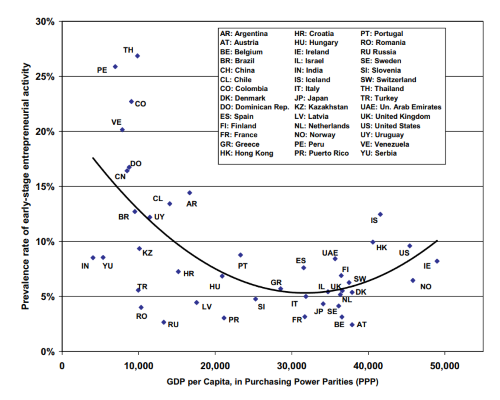
##### Bosma, N., K. Jones, E. Autio, and J. Levie (2008), Global Entrepreneurship Monitor, 2007 Executive Report. MA, US/London Business School, London, UK: Babson College, Babson Park.
###### Startup Ecosystems
The world map below also features the top 46 startup ecosystems according to the The Global Startup Ecosystem Report 2021 (Startup Genome, 2021). These are represented by the interactive bubbles: by zooming-in and clicking on individual red bubbles, a pop-up with the corresponding startup ecosystem name will appear. Startup ecosystems are "clusters of startups and related entities that draw from a shared pool of resources” (Startup Genome, 2021). Which informs our understanding of their placement on the world map, as the startup ecosystems are located at startup-dense areas, which gives startups and other organizations within the ecosystem the opportunity to support and inspire eachoter.   
##### Startup Genome. (2021). The Global Startup Ecosystem Report 2021. https://startupgenome.com/reports/gser2021

In [ ]:
# longitude & latitude for Ecosystems
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='598198nc@eur.nl')

list_ecosystem = list(pd.read_excel("Secondary Data.xlsx", sheet_name = 'Startup Ecosystem top 36 (21)')['Cities'])

data = {'ecosystem': list_ecosystem}
df_eco = pd.DataFrame(data)
df_eco['city'] = ['San Francisco', 'New York City', 'London', 'Beijing', 'Boston', 
                  'Los Angeles', 'Tel Aviv', 'Shanghai', 'Tokyo', 'Seattle', 'Washington, D.C.', 
                  'Paris', 'Amsterdam', 'Toronto', 'Waterloo', 'Chicago', 'Seoul', 'Stockholm', 
                  'Singapore', 'Shenzhen', 'Austin', 'San Diego', 'Berlin', 'Bangalore', 'Sydney', 
                  'Hangzhou', 'Atlanta', 'Denver', 'Boulder', 'Philadelphia', 'Vancouver', 
                  'Salt Lake City', 'Provo', 'Dallas', 'Hong Kong', 'Montreal', 'Munich', 
                  'Sao Paulo', 'Geneva', 'Delhi', 'Dublin', 'Melbourne', 'Raleigh', 'Durham', 
                  'Chapel Hill']

df_eco['Latitude'] = 0
df_eco['Longitude'] = 0
df_eco = df_eco.astype({'Latitude': 'float', 'Longitude': 'float'})

for i in range(0, len(df_eco.index)):
    loc = geolocator.geocode(df_eco.iloc[i]['city'])
    df_eco.at[i,'Latitude'] = loc.latitude
    df_eco.at[i,'Longitude'] = loc.longitude
    
countries = {}
for country in pycountry.countries:
    countries[country.alpha_3] = country.name
dforg['country'] = [countries.get(country, 'Unknown code') for country in dforg['country_code']]
df_country_count = dforg.groupby(['country']).size().reset_index(name='count')

world_geo = r'custom.geo.json'
with open(world_geo) as world_file:
    world_json = json.load(world_file)

countries_json = []
for index in range(len(world_json['features'])):
    countries_json.append(world_json['features'][index]['properties']['name'])

for country in countries_json:
    if country not in df_country_count['country']:
        df_country_count.loc[df_country_count.shape[0]] = [country, 0]

df_country_count = df_country_count.drop_duplicates(subset=['country'], keep='first')
        
df_country_count['log_count'] = np.log2(df_country_count['count'])
df_country_count = df_country_count.replace(-float('inf'), 0)

world_map= folium.Map(location=[20, 7], zoom_start = 2, tiles="cartodbpositron")

world_map.choropleth(
    geo_data=world_geo,
    data=df_country_count,
    columns=['country', 'log_count'],
    key_on='feature.properties.name',
    fill_color='Greys', 
    fill_opacity=0.7, 
    line_opacity=1,
    legend_name='Log Startup Count',
    smooth_factor=0)

from folium.plugins import MarkerCluster
marker_cluster = MarkerCluster().add_to(world_map)
#for each coordinate, create circlemarker of user percent
for i in range(len(df_eco)):
        lat = df_eco.iloc[i]['Latitude']
        long = df_eco.iloc[i]['Longitude']
        folium.CircleMarker(location = [lat, long], 
                            radius=5, 
                            fill =True,
                            popup= df_eco.iloc[i]['ecosystem'],
                            color='red',
                            fill_color='tomato',
                            fill_opacity=0.5).add_to(marker_cluster)

world_map

#### Operating Status By Founding Year

###### Growing number of startups
The plot clearly shows an increasing trend in the number of startups which are founded each year over the course of 1995-2012. The Global Startup Ecosystem Report of 2015 from Startup Genome, gives four reasons for this rapid growth in startups: 1) starting a startup has become a lot cheaper, which enables a more people to follow an entrepreneurial dream, 2) the decrease in capital needed to finance a startup has stimulated a wider variety of investors, thereby increasing a startup's chance to gain funding, 3) over time entrepreneurship has expanded its own category in management science, therefore establishing a better understanding of how to successfully run a startup, 4) due to developments in technology over the past centuries, the speed with which consumers adapt to new techonologies has increased, thereby enabling and stimulating more disruptive innovations, which are often associated with startups. 
##### Startup Genome. (2015, July). Global Startup Ecosystem Report 2015. https://startupgenome.com/reports/global-startup-ecosystem-report-2015
###### Decrease of startups around 2013-2014 
The decrease in startups around 2013 and 2014 can potentially originate from the data collection process. We susspect that the provided datasets might originate from a startup database platform like Crunchbase, which are dependend on the self-reported information of startups. As many founders first need approximately one to three years before fully commiting to their startup, they are often not directly focussed on registrating their startup on a startup database platform, such as Crunchbase. Therefore, eventhough a startup was founded in 2013, it might not be registered on a website such as Crunchbase, untill a few years later. 
###### Improportional growth of closed and acquired startups
Two reasons for the improportional growth of closed and acquired startups compared to the increase in operating startups, are: 1) As the horizontal axis of the plot is the founding year of the startup, and the data has been retreived in 2015, it makes sense that we have less acquired startups in the years from 2010-2015, as young startups of age 1-5 years are acquired less, due to a lack of establishment and stability. Additionally, 2) it might not be a highest priority of a founder or Top Management Team (TMT) to update their information on a website like Crunchbase once their company has been acquired, or has folded. Therefore, explaining why more recent acquisitions and closes might be less captured by recent data. 

In [ ]:
# Creating a dataframe of the status of operations of all startups grouped by the year of founding
YFU = dforg.groupby('founding_year')['Unknown'].sum()
YFA = dforg.groupby('founding_year')['acquired'].sum()
YFC = dforg.groupby('founding_year')['closed'].sum()
YFO = dforg.groupby('founding_year')['operating'].sum()

YFBreakdown = pd.concat([YFU,YFA,YFC,YFO],axis=1).reset_index()

# Creating a cumulative line chart of the distribution of startup statuses between 1990 and 2015
# Creating a stacked bar chart of the operational status for startups by founding year dataframe
YFBreakdown.plot.bar(x = 'founding_year', stacked=True, 
                          ylabel = 'Startup Status Count', 
                          xlabel = 'Year of Founding',
                          title  = 'Number of Startups Per Status Per Founding Year',
                          fontsize = 12, grid = True, figsize=(8, 6),
                          color = ['darkgrey', 'Crimson', 'tomato', 'lightpink'])
plt.xticks(rotation=75);

#### Evolution of Total Funding

###### General Trend
The trend of total funding, for the years in which startups receive their last funding, is not obvious to interpret. Nevertheless, based on the current trend of total funding: startups receiving over 643 billion USD of funding during the year 2021 (Teare, 2022), an almost doubling of that of 2020, we could interpret the trend below as a positive one. 
##### Teare, G. (2022, January 21). Global Venture Funding And Unicorn Creation In 2021 Shattered All. . . Crunchbase News. https://news.crunchbase.com/news/global-vc-funding-unicorns-2021-monthly-recap/

###### The Dotcom Bubble
The trendline between 1996 and 2002 poses most issues to our interpretation of the overall trendline. However, the observed trends can be easily explained by the Dotcom Bubble. The Dotcom bubble was a stock market bubble caused by speculation in internet-based businesses during which "the Internet sector earned over 1000% returns on its public equity" (Ofek & Richardson, 2003). However, these returns also dissapeared soon after when the Dotcom Bubble bursted. The Dotcom bubble is probably one of the causes of the trendline disruption around 2000. 
##### Ofek, E., & Richardson, M. (2003). DotCom Mania: The Rise and Fall of Internet Stock Prices. The Journal of Finance, 58(3), 1113–1137. https://doi.org/10.1111/1540-6261.00560

In [ ]:
# Line chart to display the average total funding per year in which startups received their last funding between 1995-2015
TotFunperFUNL = dforg.groupby('last_funding_year')['funding_total_usd'].mean().astype(int)
TotFunperFUNL.index.astype(str)

TotFunperFUNL.plot(xlabel = 'Year of Last Funding',
                ylabel = 'Average Total Funding in USD',
                title = 'Average Total Funding \n (Per Year of Last Funding)',figsize=(8, 6))
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlim(1995, 2014)
plt.xticks(rotation=45);

#### Evolution of Funding Time

###### General Trend
Below, the trend of days between funding rounds, for startups which had more than one funding round, is visualised. The general trend shows a clear decrease in average time between funding rounds. This might indicate that the funding process has sped up a lot compared to earlier decades. An article in Forbes from 2019 (Cremades, 2019) said that on average it takes a startup between 12 and 20 months to establish a new funding round. The strongly declining days between funding rounds should therefore be taken with a grain of salt. Additionally, it should be noted that the increase in average days between funding rounds between 1995 and 1997 might be the result of highly varying number of companies which achieved multiple funding rounds between 1195 and 1997.
##### Cremades, A. (2019, January 3). How Long It Takes To Raise Capital For A Startup. Forbes. https://www.forbes.com/sites/alejandrocremades/2019/01/03/how-long-it-takes-to-raise-capital-for-a-startup/?sh=6dc37bc67a41

In [ ]:
# Line chart to display the number of days between funding rounds between 1995-2015
dforg2 = dforg[dforg['funding_rounds']>1]
daysperFUNF = dforg2.groupby('first_funding_year')['DaysPerRound'].mean().astype(int)
daysperFUNF.index.astype(str)

daysperFUNF.plot(xlabel = 'Year of First Funding',
                ylabel = 'Average Days Per Funding Round',
                title = 'Average Days Between Funding Rounds \n (Per Year of First Funding)',figsize=(8, 6))
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xticks(rotation=45);

#### Pressence of Investor Types in Funding Rounds

A clear increasing trend of funding rounds is shown below, only experiencing a small drop around 2008 which can be explained by the financial crisis. Additionally, the pressence of all types of investors (either only venture investors, angel investors, or a mix of angel and venture investors) has increased over the years. This can be explained by the Global Startup Ecosystem Report of 2015, which states that the decrease in capital needed to finance a startup has stimulated a wider variety of investors.
##### Startup Genome. (2015, July). Global Startup Ecosystem Report 2015. https://startupgenome.com/reports/global-startup-ecosystem-report-2015

In [ ]:
typeOrg = dfinv.groupby('funded_year')['organization'].sum()
typeOrgPer = dfinv.groupby('funded_year')['organization,person'].sum()
typePer = dfinv.groupby('funded_year')['person'].sum()
InvBreakdown = pd.concat([typeOrg, typeOrgPer, typePer], axis = 1).reset_index()
InvBreakdown.plot.bar(x = 'funded_year', stacked=True, 
                          ylabel = 'Number of funding rounds', 
                          xlabel = 'Year of funding',
                          color = ['lightpink', 'tomato', 'Crimson'],
                          title  = 'Pressence of Investor Types per Funding Round',
                          fontsize = 12, grid = True,figsize=(8, 6))
plt.legend(title = 'Investor type', labels = ['Venture', 'Venture & Angel', 'Angel']);
plt.xticks(rotation=50);

#### Evolution of Acquisitions

The number of acquisitions has been very low over the first years of our research timeframe. Around 2003, the number of acquisitions increases with a slight setback around the financial crisis in 2008 and a bigger drop around 2012. In 2011, a specialist on mergers and acquisitions issues, Paul Parker, was quoted by researchers: “Prospects for 2012 are grim. Either there will be a stabilization of the European [debt] crisis and a recovery of the merging activity, or deterioration and an even worse situation” (Triantafyllopoulos & Mpourletidis, 2014). This might provide an explanation for the drop in acquisitions around 2012. 
##### Triantafyllopoulos, Y., & Mpourletidis, K. (2014). Mergers and Acquisitions and Economic Crisis. A Case Study Approach from a Qualitative Analysis in Greece. Procedia - Social and Behavioral Sciences, 148, 437–445. https://doi.org/10.1016/j.sbspro.2014.07.063

In [ ]:
dfacq.groupby('acquired_year')['price_amount'].count().plot(title='Number of Acquisitions per Year',figsize=(8, 6),
                                                           xlabel = 'Year of Acquisition', ylabel = 'Count of Acquisitions');
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xticks(rotation=45);

## Market Trends

#### Top 10 Markets by Average Total Funding

Below are three plots on the top 10 markets by average total funding, each for a different period in which startups are founded. The first thing which may grab your attention is the diversity of markets which are featured by the top 10 in each plot. The only two markets which are featured twice are the Oil & Gas market and the Solar market. Nevertheless, different overarching market categories can be defined, such as Energy, Technology and Media, which are well represented in each plot. 

In [ ]:
# Create founding decades
dforg['DecadeFOU'] = (dforg['founding_year']//10)*10
dfacq['Decade'] = (dfacq['acquired_year']//10)*10

# Change column to numeric
dforg['funding_total_usd'] = pd.to_numeric(dforg['funding_total_usd'])
dforg['market'] = dforg['market'].astype(str)

# Change similar market
dforg['market'].replace(' Oil and Gas ', ' Oil & Gas ', inplace = True)

# Create all necessary dataframes
dforgMarkets = dforg.groupby(['market','DecadeFOU'], as_index = False)['funding_total_usd'].mean()
dforgMarkets1990 = dforgMarkets[dforgMarkets['DecadeFOU'] == 1990].nlargest(n=10, columns = ['funding_total_usd']).drop('DecadeFOU', axis = 1)
dforgMarkets2000 = dforgMarkets[dforgMarkets['DecadeFOU'] == 2000].nlargest(n=10, columns = ['funding_total_usd']).drop('DecadeFOU', axis = 1)
dforgMarkets2010 = dforgMarkets[dforgMarkets['DecadeFOU'] == 2010].nlargest(n=10, columns = ['funding_total_usd']).drop('DecadeFOU', axis = 1)

#Create a plot for 1995-2000
labels = dforgMarkets1990['market'].to_list()
percentages = dforgMarkets1990['funding_total_usd'].to_numpy()*100/dforgMarkets1990['funding_total_usd'].to_numpy().sum()
dforgMarkets1990.plot.pie(y= 'funding_total_usd',
                          figsize=(5, 5),
                          title = "Top 10 Funded Markets 1995-2000", labels = None,
                          ylabel = 'Share of Average Total Funding',
                          colors = ['black', 'grey','darkgrey', 'lightgrey', 'whitesmoke', 
                                    'mistyrose', 'lightpink', 'tomato', 'red', 'darkred'])
plt.legend(bbox_to_anchor=(1.7,0.9), loc='upper right', title = 'Market',
            labels=['%s, %1.1f %%' % (l, s) for l, s in zip(labels,percentages)])
my_circle=plt.Circle( (0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

#Create a plot for 1995-2000
labels = dforgMarkets2000['market'].to_list()
percentages = dforgMarkets2000['funding_total_usd'].to_numpy()*100/dforgMarkets2000['funding_total_usd'].to_numpy().sum()
dforgMarkets2000.plot.pie(y= 'funding_total_usd',
                          figsize=(5, 5),
                          title = "Top 10 Funded Markets 2000-2010", labels = None,
                         ylabel = 'Share of Average Total Funding',
                          colors = ['black', 'grey','darkgrey', 'lightgrey', 'whitesmoke', 
                                    'mistyrose', 'lightpink', 'tomato', 'red', 'darkred'])
plt.legend(bbox_to_anchor=(1.7,0.9), loc='upper right', title = 'Market',
            labels=['%s, %1.1f %%' % (l, s) for l, s in zip(labels,percentages)])
my_circle=plt.Circle( (0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

#Create a plot for 1995-2000
labels = dforgMarkets2010['market'].to_list()
percentages = dforgMarkets2010['funding_total_usd'].to_numpy()*100/dforgMarkets2010['funding_total_usd'].to_numpy().sum()
dforgMarkets2010.plot.pie(y= 'funding_total_usd',
                          figsize=(5, 5),
                          title = "Top 10 Funded Markets 2010-2015", labels = None,
                         ylabel = 'Share of Average Total Funding',
                          colors = ['black', 'grey','darkgrey', 'lightgrey', 'whitesmoke', 
                                    'mistyrose', 'lightpink', 'tomato', 'red', 'darkred'])
plt.legend(bbox_to_anchor=(1.8,0.9), loc='upper right', title = 'Market',
            labels=['%s, %1.1f %%' % (l, s) for l, s in zip(labels,percentages)])
my_circle=plt.Circle( (0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle);

#### Top 5 Funded Markets and Their Total Funding

The plot below shows funding trendlines for the overall top 5 funded markets, which are Biotechnology, Curated Web, E-Commerce, Mobile and Software. We can see that the curated web market spiked for companies which were founded in 1998, which is probably caused by the Dotcom Bubble. The ecommerce market experienced peaks at 1995 and 1999, which may well be caused by the Dotcom Bubble as well. Howerver, the peak weak the ecommerce market experienced during 2007, might be better explained by the rise of big platforms such as Amazon, Facebook and eBay. The peak experienced by the Biotechnology market in 2007 could be a result of a major breakthrough in stamcell research, for which Mario R. Capecchi, Martin J. Evans and Oliver Smithies obtained a Nobel Prize. 
##### The Nobel Prize. (2007). The Nobel Prize in Physiology or Medicine 2007. NobelPrize.Org. https://www.nobelprize.org/prizes/medicine/2007/summary/

In [ ]:
# Create all necessary dataframes
dforgMarketsCount = dforg.groupby('market', as_index = False)['funding_total_usd'].count()
dforgMarketsAllTop5 = dforgMarketsCount.nlargest(n=5, columns = ['funding_total_usd'])
dforgMarketsName = dforgMarketsAllTop5['market']
dforgMarketsName.drop_duplicates(inplace = True)

dforgMarketsCountAll = dforg.groupby(['market', 'founding_year'], as_index = False)['funding_total_usd'].mean()
dforgMarketsCountAll = dforgMarketsCountAll.loc[dforgMarketsCountAll['market'].isin(dforgMarketsName)]
dforgMarketsCountAll = dforgMarketsCountAll.pivot(index = 'founding_year', columns = 'market', values = 'funding_total_usd')

dforgMarketsAvePlot = sns.relplot(estimator=None,
                                    kind="line", 
                                    height=5, 
                                    marker="o", 
                                    legend = False,
                                    dashes = False,
                                    aspect=12/5,
                                    palette = ['lightpink', 'red', 'firebrick','grey', 'black'],
                                    data=dforgMarketsCountAll).set(xticks=dforgMarketsCountAll.index,
                                                                   title='Average Funding per Year of the 5 Biggest Markets',
                                                                  xlabel = 'Year of Founding', ylabel = 'Average Funding Amount in USD')
plt.legend(title='Markets', labels = dforgMarketsCountAll.columns);
plt.xticks(rotation=45);

dforgMarketsAllCum = dforg.groupby(['market', 'founding_year'], as_index = False)['funding_total_usd'].sum()
dforgMarketsAllCum = dforgMarketsAllCum.loc[dforgMarketsAllCum['market'].isin(dforgMarketsName)]
dforgMarketsAllCum['CumSum'] = dforgMarketsAllCum.groupby(['market'], as_index = False)['funding_total_usd'].cumsum()

dforgMarketsAllCum = dforgMarketsAllCum.pivot(index = 'founding_year', columns = 'market', values = 'CumSum')

dforgMarketsCummPlot = sns.relplot(estimator=None,
                                    kind="line", 
                                    height=5, marker="o", 
                                    legend = False,
                                    dashes=False,aspect=12/5,
                                    palette = ['lightpink', 'red', 'firebrick','grey', 'black'],
                                    data=dforgMarketsAllCum).set(xticks=dforgMarketsAllCum.index,
                                                                 title='Cumulative Sum of Funding per Year of the 5 Biggest Markets',
                                                                xlabel = 'Year of Founding', ylabel = 'Cumulative Sum of Funding')
plt.legend(title='Markets', labels = dforgMarketsAllCum.columns);
plt.xticks(rotation=45);

#### Top 10 Markets by Average Investments

Below are three plots on the top 10 markets by average investments, each for a different period of time. Once again, the diversity featured by the different plots is quite remarkable. However, energy markets are not featured by the presented top 10. Instead an overwheleming majority of top 10 markets is focussed on either techonology or media markets. The difference between the three plots on average total funding per founding period and the plots below clearly shows that the markets in which is most invested over the years, is not the same as the markets which established the highest overal funding. The investment context clearly plays an important role to pinpoint the biggest investment opportunities, whilst some investments, such as the ones shown below, might be a safer investment in general. 

In [ ]:
# Create all necessary dataframes
dfinvMarkets = dfinv.groupby(['investor_market','funded_decade'], as_index = False)['amount_divided'].mean()
dfinvMarkets1990 = dfinvMarkets[dfinvMarkets['funded_decade'] == 1990].nlargest(n=10, columns = ['amount_divided']).drop('funded_decade', axis = 1)
dfinvMarkets2000 = dfinvMarkets[dfinvMarkets['funded_decade'] == 2000].nlargest(n=10, columns = ['amount_divided']).drop('funded_decade', axis = 1)
dfinvMarkets2010 = dfinvMarkets[dfinvMarkets['funded_decade'] == 2010].nlargest(n=10, columns = ['amount_divided']).drop('funded_decade', axis = 1)

labels = dfinvMarkets1990['investor_market'].to_list()
percentages = dfinvMarkets1990['amount_divided'].to_numpy()*100/dfinvMarkets1990['amount_divided'].to_numpy().sum()

dfinvMarkets1990.plot.pie(y= 'amount_divided',
                          figsize=(5, 5),
                          title = "Top 10 Investor Markets 1995-2000", labels = None,
                          ylabel = 'Share of Total Investor Activity',
                          colors = ['black', 'grey','darkgrey', 'lightgrey', 'whitesmoke', 
                                    'mistyrose', 'lightpink', 'tomato', 'red', 'darkred'])
plt.legend(bbox_to_anchor=(1.75,0.9), loc='upper right', title = 'Market',
            labels=['%s, %1.1f %%' % (l, s) for l, s in zip(labels,percentages)])
my_circle=plt.Circle( (0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

labels = dfinvMarkets2000['investor_market'].to_list()
percentages = dfinvMarkets2000['amount_divided'].to_numpy()*100/dfinvMarkets2000['amount_divided'].to_numpy().sum()

dfinvMarkets2000.plot.pie(y= 'amount_divided',
                          figsize=(5, 5),
                          title = "Top 10 Investor Markets 2000-2010", labels = None,
                          ylabel = 'Share of Total Investor Activity',
                          colors = ['black', 'grey','darkgrey', 'lightgrey', 'whitesmoke', 
                                    'mistyrose', 'lightpink', 'tomato', 'red', 'darkred'])
plt.legend(bbox_to_anchor=(1.7,0.9), loc='upper right', title = 'Market',
            labels=['%s, %1.1f %%' % (l, s) for l, s in zip(labels,percentages)])
my_circle=plt.Circle( (0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

labels = dfinvMarkets2010['investor_market'].to_list()
percentages = dfinvMarkets2010['amount_divided'].to_numpy()*100/dfinvMarkets2010['amount_divided'].to_numpy().sum()

dfinvMarkets2010.plot.pie(y= 'amount_divided',
                          figsize=(5, 5),
                          title = "Top 10 Investor Markets 2010-2015", labels = None,
                          ylabel = 'Share of Total Investor Activity',
                          colors = ['black', 'grey','darkgrey', 'lightgrey', 'whitesmoke', 
                                    'mistyrose', 'lightpink', 'tomato', 'red', 'darkred'])
plt.legend(bbox_to_anchor=(1.7,0.9), loc='upper right', title = 'Market',
            labels=['%s, %1.1f %%' % (l, s) for l, s in zip(labels,percentages)])
my_circle=plt.Circle( (0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle);

#### Top 10 Markets by Average Acquisition Expenditure

Below are three plots on the top 10 markets by average acquisition amount, each for a different period of time. As, accoriding to our data, there were only two markets in which acquisition(s) took place between 1995 and 2000, Web-Hosting and E-Commerce make up for the top 10 in this period. For the periods which follow, we can distinguish that platform-based markets such as Social Network Media and Peer-to-Peer have played an important role in the world of acquisition. An example of such an acquisition is the that of Whatsapp, which Facebook acquired in 2014 for approximately 20 billion USD. 

In [ ]:
dfacqMarkets = dfacq.groupby(['company_market','Decade'], as_index = False)['price_amount_USD'].mean()
dfacqMarkets1990 = dfacqMarkets[dfacqMarkets['Decade'] == 1990].nlargest(n=10, columns = ['price_amount_USD']).drop('Decade', axis = 1)
dfacqMarkets2000 = dfacqMarkets[dfacqMarkets['Decade'] == 2000].nlargest(n=10, columns = ['price_amount_USD']).drop('Decade', axis = 1)
dfacqMarkets2010 = dfacqMarkets[dfacqMarkets['Decade'] == 2010].nlargest(n=10, columns = ['price_amount_USD']).drop('Decade', axis = 1)

#drop the Biotechnology Market as the price amount is not known
dfacqMarkets1990 = dfacqMarkets1990.drop([31])
labels = dfacqMarkets1990['company_market'].to_list()
percentages = dfacqMarkets1990['price_amount_USD'].to_numpy()*100/dfacqMarkets1990['price_amount_USD'].to_numpy().sum()

dfacqMarkets1990.plot.pie(y= 'price_amount_USD',
                          figsize=(5, 5),
                          title = "Top 10 Acquisition Markets 1995-2000", labels = None,
                          ylabel = 'Share of Market by Acquisiton Expenditure',
                          colors = ['black', 'grey','darkgrey', 'lightgrey', 'whitesmoke', 
                                    'mistyrose', 'lightpink', 'tomato', 'red', 'darkred'])
plt.legend(bbox_to_anchor=(1.5,0.9), loc='upper right', title = 'Market',
            labels=['%s, %1.1f %%' % (l, s) for l, s in zip(labels,percentages)])
my_circle=plt.Circle( (0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

labels = dfacqMarkets2000['company_market'].to_list()
percentages = dfacqMarkets2000['price_amount_USD'].to_numpy()*100/dfacqMarkets2000['price_amount_USD'].to_numpy().sum()

dfacqMarkets2000.plot.pie(y= 'price_amount_USD',
                          figsize=(5, 5),
                          title = "Top 10 Acquisition Markets 2000-2010", labels = None,
                          ylabel = 'Share of Market by Acquisiton Expenditure',
                          colors = ['black', 'grey','darkgrey', 'lightgrey', 'whitesmoke', 
                                    'mistyrose', 'lightpink', 'tomato', 'red', 'darkred'])
plt.legend(bbox_to_anchor=(1.7,0.9), loc='upper right', title = 'Market',
            labels=['%s, %1.1f %%' % (l, s) for l, s in zip(labels,percentages)])
my_circle=plt.Circle( (0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

labels = dfacqMarkets2010['company_market'].to_list()
percentages = dfacqMarkets2010['price_amount_USD'].to_numpy()*100/dfacqMarkets2010['price_amount_USD'].to_numpy().sum()

dfacqMarkets2010.plot.pie(y= 'price_amount_USD',
                          figsize=(5, 5),
                          title = "Top 10 Acquisition Markets 2010-2015", labels = None,
                          ylabel = 'Share of Market by Acquisiton Expenditure',
                          colors = ['black', 'grey','darkgrey', 'lightgrey', 'whitesmoke', 
                                    'mistyrose', 'lightpink', 'tomato', 'red', 'darkred'])
plt.legend(bbox_to_anchor=(1.7,0.9), loc='upper right', title = 'Market',
            labels=['%s, %1.1f %%' % (l, s) for l, s in zip(labels,percentages)])
my_circle=plt.Circle( (0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle);

#### Top 5 Acquisition Markets and their Acquisition Expenditure

The plot below shows acquisition trendlines for the overall top 5 acquisition markets, which are Biotechnology, Curated Web, Enterprise Software, Mobile and Software. When comparing this top 5 to that of total funding, we can see that four markets of the five are featured in each plot. This emphasises the importance and attractiveness of these markets to investors and acquirers. As acquisitions in the top 5 markets only took place from 2004 on, the plot also only includes years from 2004 on. The first peak we notice is that of the Mobile market at 2005, is caused by the acquisition of Skype by eBay, which was an expenditure of 2.6 billion USD. As this acquisition is the only one the Mobile market experienced in 2005, this acquisition causes a big peak in the average acquisition expenditure plot. The second peak which is experienced by the Mobile market is once again Skype. However this time, Skype was acquired from eBay by Microsoft for approximately 8.5 billion USD. Another noticeable peak is that of Curated Web in 2009. This peak was caused by Amazon acquiring Zappos, an online retailing company, for 1.2 billion USD. Important to note is that the aggregation to average acquisition expenditure might skew the perspective of how much total acquisition expenditure is spend per market. Therefore, we additionally added a trendline plot on the cumulative sum of acquisition expenditure. However, the number of acquisitions per year per market are not featured, so this should taken into consideration during interpretation. 

In [ ]:
# Create all necessary dataframes
dfacqMarketsCount = dfacq.groupby('company_market', as_index = False)['price_amount_USD'].count()
dfacqMarketsAllTop5 = dfacqMarketsCount.nlargest(n=5, columns = ['price_amount_USD'])
dfacqMarketsName = dfacqMarketsAllTop5['company_market']
dfacqMarketsName.drop_duplicates(inplace = True)

dfacqMarketsCountAll = dfacq.groupby(['company_market', 'acquired_year'], as_index = False)['price_amount_USD'].mean()
dfacqMarketsCountAll = dfacqMarketsCountAll.loc[dfacqMarketsCountAll['company_market'].isin(dfacqMarketsName)]

dfacqMarketsCountAll = dfacqMarketsCountAll.pivot(index = 'acquired_year', columns = 'company_market', values = 'price_amount_USD')

dfacqMarketsCountAll = dfacqMarketsCountAll[dfacqMarketsCountAll.index > 2003]

dfacqMarketsAvePlot = sns.relplot(estimator=None,
                                    kind="line", 
                                    height=5, 
                                    marker="o", 
                                    legend = False,
                                    dashes = False,
                                    palette = ['lightpink', 'red', 'firebrick','grey', 'black'],
                                    aspect=12/5,data=dfacqMarketsCountAll).set(xticks=dfacqMarketsCountAll.index,
                                                                               title='Average Acquisition Expenditures of the 5 Biggest Markets',
                                                                              xlabel = 'Year of Acquisition', ylabel ='Average Acquisition Expenditure in USD')
plt.legend(title='Markets', labels = dfacqMarketsCountAll.columns);
plt.xticks(rotation=45);

dfacqMarketsAllCum = dfacq.groupby(['company_market', 'acquired_year'], as_index = False)['price_amount_USD'].sum()
dfacqMarketsAllCum = dfacqMarketsAllCum.loc[dfacqMarketsAllCum['company_market'].isin(dfacqMarketsName)]
dfacqMarketsAllCum['CumSum'] = dfacqMarketsAllCum.groupby(['company_market'], as_index = False)['price_amount_USD'].cumsum()

dfacqMarketsAllCum = dfacqMarketsAllCum.pivot(index = 'acquired_year', columns = 'company_market', values = 'CumSum')

dfacqMarketsAllCum = dfacqMarketsAllCum[dfacqMarketsAllCum.index > 2003]

dfacqMarketsCummPlot = sns.relplot(estimator=None,
                                    kind="line", 
                                    height=5, 
                                    marker="o",
                                    legend = False,
                                    dashes = False,
                                    aspect=12/5,
                                    palette = ['lightpink', 'red', 'firebrick','grey', 'black'],
                                    data=dfacqMarketsAllCum).set(xticks=dfacqMarketsAllCum.index,
                                                                 title='Cumulative Sum of Acquisition Expenditure of the 5 Biggest Markets',
                                                                xlabel = 'Year of Acquisition', ylabel = 'Cumulative Acquisition Expenditure in USD')
plt.legend(title='Markets', labels = dfacqMarketsAllCum.columns);
plt.xticks(rotation=45);

## Country Trends

#### Investments

###### Dominance of American Investments
It is commonly known that The United States of America has a vibrand startup economy. This is also visualised the the first plot below, showcasing the cumulitive investment of the top 5 highest investing countries, in which the USA displays its dominance. 

###### Investing Countries
When we take the top 5 highest investing countries, aggregate the investments done by investors from these countries, and plot them per year, we get the trendlines as depicted in the second graph below. From this we can derive that in general, the American investors have always had relatively high average investments. However, we can also see that the investors from runner up countries, also do not have such low average investments compared to the USA. Nevertheless, these results should be interpeted with caution due to the influence of scarse sub-categories, as displayed by the peak of France at 2000, which is caused by the four investments of French investors, of which three were around the 40 thousand USD mark, causing a high peak which is not generalizable to the rest of the data.

###### Receiving Countries
In the third plot below, we see the average received investment of the top 5 most frequently receiving countries. When we compare the second and third plot, we can see that French investors invested a lot in startups which were not French, but were probably from the USA or Great Brittain. This is indeed the case, as three of the four investments, the ones mentioned above, are in American startups. Additionally, according to the data, Canadian startups did not receive investments before 2004, but Canadian investors did invest in startups from other countries. Once again, the plot should be interpeted with caution, as the peak from Great Brittain at 2002 is caused by a small amount of investments from which one amounts to 60 thousand USD. Thereby, causing the peak. 

In [ ]:
investor=pd.DataFrame(dfinv.groupby(['funded_year','investor_country_code'])['raised_amount_usd'].sum().reset_index(level=['funded_year','investor_country_code']))
top5=pd.DataFrame(dfinv.groupby(['investor_country_code'])['raised_amount_usd'].count().sort_values(ascending=False).reset_index(level=['investor_country_code']).head(5))
investor['cumsum']=pd.DataFrame(investor.groupby('investor_country_code')['raised_amount_usd'].transform('cumsum'))
investor= investor[investor['investor_country_code'].isin(top5['investor_country_code'].to_list())].reset_index().rename(columns={'cumsum':'cumulative investment'})

sns.relplot(x="funded_year", y="cumulative investment", 
            hue="investor_country_code", 
            estimator=None,
            kind="line", height=5, marker="o",
            aspect=12/5,
            palette = ['red', 'firebrick','lightpink', 'grey','black'],
            data=investor).set(xticks=investor['funded_year'],
            title='Cumulative Investment of the Top 5 Most Frequently Investing Countries',
            xlabel = 'Year of Funding', 
            ylabel = 'Investments in USD')
plt.xticks(rotation=45)
ax = plt.gca()
ax.set_xlim([1998.5, 2014.5]);

investor=pd.DataFrame(dfinv.groupby(['funded_year','investor_country_code'])['raised_amount_usd'].mean().sort_values(ascending=False).reset_index(level=['funded_year','investor_country_code']))
top5=pd.DataFrame(dfinv.groupby(['investor_country_code'])['raised_amount_usd'].count().sort_values(ascending=False).reset_index(level=['investor_country_code']).head(5))
investor= investor[investor['investor_country_code'].isin(top5['investor_country_code'].to_list())]

sns.relplot(x="funded_year", y="raised_amount_usd", 
            hue="investor_country_code", estimator=None,
            kind="line", height=5, marker="o",
            aspect=12/5,
            palette = ['lightpink', 'red', 'firebrick','grey', 'black'],
            data=investor).set(xticks=investor['funded_year'],
                               title='Average Investment of the Top 5 Most Frequently Investing Countries',
                               xlabel = 'Year of Funding', ylabel = 'Funded Amount in USD')
plt.xticks(rotation=45);

investor=pd.DataFrame(dfinv.groupby(['funded_year','company_country_code'])['raised_amount_usd'].mean().sort_values(ascending=False).reset_index(level=['funded_year','company_country_code']))
top5=pd.DataFrame(dfinv.groupby(['company_country_code'])['raised_amount_usd'].count().sort_values(ascending=False).reset_index(level=['company_country_code']).head(5))
investor= investor[investor['company_country_code'].isin(top5['company_country_code'].to_list())]

sns.relplot(x="funded_year", y="raised_amount_usd", 
            hue="company_country_code", estimator=None,
            kind="line", height=5, marker="o",aspect=12/5,
            palette = ['grey', 'red', 'firebrick','black', 'lightpink'],
            data=investor).set(xticks=investor['funded_year'],
                               title='Average Received Investment of the Top 5 Most Frequently Receiving Countries',
                               xlabel = 'Year of Funding', ylabel = 'Investments in USD')
plt.xticks(rotation=45);

#### Acquisitions

###### Dominance of American Acquisitions
Once again, The United States displays its dominance, but this time in its expenditure in acquisitions. This is visualised by the first plot below, showcasing the cumulitive acquisition expenditure of the top 5 highest acquiring countries. Additionally, it is interesting to note that eventhough the graphs x-axis starts at either 2004 or 2007, the acquisitions in the USA already started since 1996. However, due to the lack of American acquisitions during this period, the data strongly influenced the scale of the y-axis. Due to this reason we decided to minimise the x-axis to a scale appropriate for all the included countries. 

###### Acquiring Countries
The second plot below shows the average acquisition expenditure of the top 5 most frequently acquiring countries. These incluede the USA, Great Brittain, Japan, China and Canada. The most interesting feature of this plot might be the simultaneous peak of China, Japan and Great Brittain in 2013. These peaks are caused by a total of twenty-four acquisition of which four were higher than 1 billion USD and seven were higher than 100 thousand USD.

###### Acquired Countries
The third plot below shows the average acquisition expenditure of the top 5 countries with most acquired startups. These incluede the USA, Great Brittain, Israel, China and Canada. When we compare the second and third plot, we can see more differences then when we compared the investor country and invested country plots from above. Eventhough Chineese startups were only acquired nine times according to our dataset, it still had a relatively high score in the countries with acquired startups. This is probably caused by the single peak China has at 2013, which represents an acquisition of 1.9 billion USD. 

In [ ]:
acquisition=pd.DataFrame(dfacq.groupby(['acquired_year','acquirer_country_code'])['price_amount_USD'].sum().reset_index(level=['acquired_year','acquirer_country_code']))
top5=pd.DataFrame(dfacq.groupby(['acquirer_country_code'])['price_amount_USD'].count().sort_values(ascending=False).reset_index(level=['acquirer_country_code']).head(5))
acquisition['cumsum']=pd.DataFrame(acquisition.groupby('acquirer_country_code')['price_amount_USD'].transform('cumsum'))
acquisition= acquisition[acquisition['acquirer_country_code'].isin(top5['acquirer_country_code'].to_list())].reset_index().rename(columns={'cumsum':'cumulative acquisition'})

sns.relplot(x="acquired_year", y="cumulative acquisition", 
            hue="acquirer_country_code", estimator=None, 
            kind="line", height=5, marker="o",aspect=12/5,
            palette = ['red', 'firebrick','grey', 'black', 'lightpink'],
            data=acquisition).set(xticks=acquisition['acquired_year'],
                                  title='Cumulative Acquisition Amounts of the Top 5 Most Frequently Acquiring Countries',
                                  xlabel = 'Acquisition Year', ylabel = 'Acquisition Expenditure in USD')
plt.xticks(rotation=45)
ax = plt.gca()
ax.set_xlim([2006.5, 2014.5]);

acquisition=pd.DataFrame(dfacq.groupby(['acquired_year','acquirer_country_code'])['price_amount_USD'].mean().sort_values(ascending=False).reset_index(level=['acquired_year','acquirer_country_code']))
top5=pd.DataFrame(dfacq.groupby(['acquirer_country_code'])['price_amount_USD'].count().sort_values(ascending=False).reset_index(level=['acquirer_country_code']).head(5))
acquisition= acquisition[acquisition['acquirer_country_code'].isin(top5['acquirer_country_code'].to_list())]

sns.relplot(x="acquired_year", y="price_amount_USD", 
            hue="acquirer_country_code", estimator=None, 
            kind="line", height=5, marker="o",aspect=12/5,
            palette = ['red', 'grey', 'black','lightpink', 'firebrick'],
            data=acquisition).set(xticks=acquisition['acquired_year'],
                                  title='Average Acquisition Amounts of the Top 5 Most Frequently Acquiring Countries',
                                  xlabel = 'Acquisition Year', ylabel = 'Acquisition Expenditure in USD')
plt.xticks(rotation=45)
ax = plt.gca()
ax.set_xlim([2006.5, 2014.5])
ax.set_ylim([None, 850000000]);

acquisition=pd.DataFrame(dfacq.groupby(['acquired_year','company_country_code'])['price_amount_USD'].mean().sort_values(ascending=False).reset_index(level=['acquired_year','company_country_code']))
top5=pd.DataFrame(dfacq.groupby(['company_country_code'])['price_amount_USD'].count().sort_values(ascending=False).reset_index(level=['company_country_code']).head(5))
acquisition= acquisition[acquisition['company_country_code'].isin(top5['company_country_code'].to_list())]

sns.relplot(x="acquired_year", y="price_amount_USD", 
            hue="company_country_code", estimator=None,
            kind="line", height=5, marker="o",aspect=12/5,
            palette = ['red', 'lightpink', 'grey','firebrick', 'black'],
            data=acquisition).set(xticks=acquisition['acquired_year'],
                                  title='Average Acquisition Amounts of the Top 5 Countries with Most Acquired Startups',
                                  xlabel = 'Acquisition Year', ylabel = 'Acquisition Expenditure in USD')
plt.xticks(rotation=45)
ax = plt.gca()
ax.set_xlim([2003.5, 2014.5])
ax.set_ylim([None, 850000000]);

## Domain Trends
As each startup in the provided dataset had a domain, we decided to also focus some of our efforts on its trends, especially considering earlier foundings and influence of the Dotcom Bubble. 

#### Domain Extensions

###### Domain Shares
First of all, it is interesting to look at the shares of different domains featured in our dataset. Below, an overview of the top 10 domains is desplayed. An overwhelming majority has a '.com' domain, followed by smaller less featured domains or no domains at all. It is also interesting to note that many domains are country or region bounded, thereby indicating in what specific geographic market a certain startup is active. 

###### Domain Growth
Based on the visualized top 10, we decided to take a closer look at the trendline of the top 6. From this we can derive that the '.com' domain has been a favourite for many years. To clarify the drop in domains in the last years ascending to 2015, it is best to reference to our possible explanations on the drop of startup counts in general for the years 2012, 2013 and 2014. 

In [ ]:
# We create a view of the top 20 and top 10 domains by frequency of occurrence in the dataframe
topdoms = dforg['Domains'].value_counts().head(20)
topdoms10 = dforg['Domains'].value_counts().head(10)

# Plotting the data in a pie chart
labels = topdoms10.index.to_list()
percentages = topdoms10.to_numpy()*100/topdoms10.to_numpy().sum()

topdoms10.plot.pie(y= 'count',
                          figsize=(5, 5),
                          title = 'Share of Domains for All Startups', labels = None,
                          colors = ['black', 'grey','darkgrey','lightgrey', 'whitesmoke', 'mistyrose', 
                                    'lightpink','tomato','red', 'darkred'])
plt.legend(bbox_to_anchor=(1.7,0.9), loc='upper right', title = 'Domains',
           labels=['%s, %1.1f %%' % (l, s) for l, s in zip(labels,percentages)])
my_circle=plt.Circle( (0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle);

# Create all necessary dataframes
topdom = dforg['Domains'].value_counts().head(20)
topdom20 = topdom.nlargest(n=6)
topdom20names = topdom20.index
top20domyear = dforg.groupby(['founding_year','Domains'], as_index = False)['Domains'].size()
top20domyearAll = top20domyear.loc[top20domyear['Domains'].isin(topdom20names)]
top20domyearAll = top20domyearAll.pivot(index = 'founding_year', columns = 'Domains', values = 'size')

# Plotting the aforementioned series in a bar chart to show domains with the largest average funding in USD
top20domPlot = sns.relplot(estimator=None,
                                    kind="line", 
                                    height=6, 
                                    marker="o", 
                                    legend = False,
                                    dashes = False,
                                    aspect=11/5,
                                    palette = ['lightgrey', 'darkgrey', 'black','firebrick','red', 'lightpink'],
                                    data=top20domyearAll).set(xticks=top20domyearAll.index,
                                                                   title='Top 6 Frequently Occuring Domains and their Registraions')
plt.xticks(rotation=45);
top20domPlot.set_ylabels('Number of Domain Registrations')
top20domPlot.set_xlabels('Founding Year')
plt.legend(title='Domains', labels = top20domyearAll.columns);

###### Top 10 Domains by Sum of Total Funding
Due to the popularity of the '.com' domain, it makes sense that the sum of total funding for the '.com' domain is a lot higher than that of other domains.

###### Top 20 Frequently Occurring Domains and their Average Total Funding
When considering the average total funding for the top 20 most occuring domains, it is interesting to note that, as there are a lot of '.com' domains used by startups, it also decreases the average total funding of startups with a '.com' domain. In this case, we see that country based domains such as '.ru', which corresponds to Russia, and '.de', which corresponds to Germany, score relatively high due to a more minimal user base. 

###### Top 20 Domains By Average Total Funding
When we only take into consideration the average total funding, we can see that less popular domains play a more important role. This can be a result from the lack of startups in the dataset with such a domain, therefore strongly increasing the average total funding.

In [ ]:
# Creating a series that shows the top 10 domains with the highest sum of funding in our dforg dataframe
sortfundsum = dforg.groupby('Domains')['funding_total_usd'].sum().sort_values(ascending=False).head(10)

# Plotting the aforementioned series in a bar chart to show domains with the largest average funding in USD
sortfundsum.reset_index().plot(x = 'Domains', y='funding_total_usd', kind='bar', 
                          ylabel = 'Total Funding Received in USD', 
                          xlabel = 'Top-Level Domain of Startups ',
                            title = 'Sum of Funding in USD Per Domain for Top 10 Domains',
                         fontsize = 12, grid = True, figsize=(10, 6));

# Creating a dataframe that shows the top domains by frequency of occurrence paired with the average
# total funding in USD startups with these domains have received
fund = dforg.groupby('Domains')['funding_total_usd'].mean()
result = pd.merge(topdoms,fund, left_index=True, right_index=True).sort_values(ascending=False, by=['funding_total_usd'])

# Plotting the values from the previous dataframe in a bar chart
result.reset_index().plot(x = 'index', y='funding_total_usd', kind='bar', 
                          ylabel = 'Total Funding Received in USD', 
                          xlabel = 'Top-Level Domain of Startups',
                          title = 'Average Total Funding Top 20 Most Frequent Domains',
                         fontsize = 12, grid = True, figsize=(8, 6));

# Creating a series that shows the top 20 domains with the highest average funding in our dforg dataframe
sortfund = dforg.groupby('Domains')['funding_total_usd'].mean().sort_values(ascending=False).head(20)

# Plotting the aforementioned series in a bar chart to show domains with the largest average funding in USD
sortfund.reset_index().plot(x = 'Domains', y='funding_total_usd', kind='bar', 
                          ylabel = 'Total Funding Received in USD', 
                          xlabel = 'Top-Level Domain of Startups ',
                            title = 'Average Total Funding for Top 20 Domains',
                         fontsize = 12, grid = True, figsize=(10, 6));

###### Top 6 Highest Funded Domains and Their Average Total Funding
As explained previously, the first plot below is influenced a lot by the number of occurances that a domain has in the dataset, this should be taken into consideration during interpretation. However, the peak of '.ru' at 2004 is worth the investigation. It turns out that there was only one startup in the dataset which was founded in 2004 and had a '.ru' domain, which solely acounted for a total funding of 625 thousand USD. With similar reasoning, the peak from the '.org' domain at 2001 can be explained: there were five startups founded in 2001 with the '.org' domain, of which one had a total funding of 1.2 billion USD. This is once more a reminder to be cautious when interpreting graphs of relatively sparse sub-categorizations.

###### Top 6 Highest Funded Domains and Their Sum of Total Funding
To put into perspective how decieving the previous plot can be, we also included the the same variables, but instead of plotting the average total funding, we plotted the sum of total funding. from this it quickly becomes clear how minimal the interpreted trends of the previous plot are. From this plot we can however see a decreasing trend in the total funding of the '.com' domain since 2007. We should leave the years 2012, 2013 and 2014 out of this interpretation, due to the decrease in startups in the dataset for these years. 

In [ ]:
#Create all necessary dataframes
topfunddom = dforg.groupby('Domains', as_index = False)['funding_total_usd'].sum()
topfunddom20 = topfunddom.nlargest(n=6, columns = ['funding_total_usd'])
topfunddom20names = topfunddom20['Domains']
topfunddom20names.drop_duplicates(inplace = True)
top20funddomyear = dforg.groupby(['Domains', 'founding_year'], as_index = False)['funding_total_usd'].mean()
top20funddomyearAll = top20funddomyear.loc[top20funddomyear['Domains'].isin(topfunddom20names)]
top20funddomyearAll = top20funddomyearAll.pivot(index = 'founding_year', columns = 'Domains', values = 'funding_total_usd')

# Plotting the aforementioned series in a bar chart to show domains with the largest average funding in USD
top20funddomPlot = sns.relplot(estimator=None,
                                    kind="line", 
                                    height=6, 
                                    marker="o", 
                                    legend = False,
                                    dashes = False,
                                    aspect=11/5,
                                    palette = ['lightpink', 'red', 'firebrick', 'lightgrey','grey', 'black'],
                                    data=top20funddomyearAll).set(xticks=top20funddomyearAll.index,
                                                                   title='Top 6 Highest Funded Domains and Their Average Total Funding')
plt.xticks(rotation=45);
top20funddomPlot.set_ylabels('Total Funding in USD')
top20funddomPlot.set_xlabels('Founding Year')
plt.legend(title='Domains', labels = top20funddomyearAll.columns);

# Create all necessary dataframes
stopfunddom = dforg.groupby('Domains', as_index = False)['funding_total_usd'].sum()
stopfunddom20 = stopfunddom.nlargest(n=6, columns = ['funding_total_usd'])
stopfunddom20names = stopfunddom20['Domains']
stopfunddom20names.drop_duplicates(inplace = True)
stop20funddomyear = dforg.groupby(['Domains', 'founding_year'], as_index = False)['funding_total_usd'].sum()
stop20funddomyearAll = stop20funddomyear.loc[stop20funddomyear['Domains'].isin(stopfunddom20names)]
stop20funddomyearAll = stop20funddomyearAll.pivot(index = 'founding_year', columns = 'Domains', values = 'funding_total_usd')

# Plotting the aforementioned series in a bar chart to show domains with the largest average funding in USD
stop20funddomPlot = sns.relplot(estimator=None,
                                    kind="line", 
                                    height=6, 
                                    marker="o", 
                                    legend = False,
                                    dashes = False,
                                    aspect=11/5,
                                    palette = ['lightpink', 'red', 'firebrick', 'lightgrey','grey', 'black'],
                                    data=stop20funddomyearAll).set(xticks=stop20funddomyearAll.index,
                                                                   title='Top 6 Highest Funded Domains and Their Sum of Total Funding')
plt.xticks(rotation=45);
stop20funddomPlot.set_ylabels('Sum of Total Funding in USD')
stop20funddomPlot.set_xlabels('Founding Year')
plt.legend(title='Domains', labels = top20funddomyearAll.columns);

#### Domain Length

###### Domain Shares
As we researched domains, we realised it might also be interesting to investigate the trends of domain lenghts. Below a the shares of the top 10 most frequently occuring domain lenght is visualized. You can see that most domains are between five and thirteen characters long. Startups without a domain are obviously represented by the share of zero characters. 

In [ ]:
# Selecting and displaying the top 10 most frequently occurring website (body) lengths for startups
toplens = dforg['DomainLength'].value_counts().head(10)
dforg = dforg.astype({'DomainLength': 'int64'})
# Plotting the aforementioned series in a pie chart
labels1 = toplens.index.to_list()
percentages1 = toplens.to_numpy()*100/toplens.to_numpy().sum()

toplens.plot.pie(y= 'count',
                          figsize=(5, 5),
                          title = 'Top 10 Frequently Used Domain Length', 
                          ylabel = 'Domain Name Length',
                          labels = None,
                          colors = ['black', 'grey','darkgrey', 'lightgrey', 'whitesmoke', 
                                    'mistyrose', 'lightpink', 'tomato', 'red', 'darkred'])
plt.legend(bbox_to_anchor=(1.7,0.9), loc='upper right', title = 'Domain Lengths',
           labels=['%s, %1.1f %%' % (l, s) for l, s in zip(labels1,percentages1)])
my_circle=plt.Circle( (0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle);

###### Top 10 Most Frequently Occuring Domain Lengths and Their Average Total Funding
Additonally to what was previously shown in the shares plot, we can see that the average total funding is quite similar for the domains with lenght between five and thirteen. A reason why these averages are closed, are probably due to the shares being divided more equally, thereby having a more similar distribution of low and high funded domains per domain length. 
###### Top 10 Highest Funded Domain Lengths and Their Average Total Funding
Comaparably to the Total Funding plots of the domain extensions, we can also see a clear difference between the average total funding of the most frequently occuring domain length and that of the highest funded domain lengths. The shorter domain lenghts like '2' and '3' were to be expected as big organizations such as IBM and General Motors (GM). However, we did not expect to see a '22' character domain perform so well on average total funding. Nevertheless, we expect this is a result of one or a few highly funded '22' character long domains, with only a few domains of that lenght in our dataset.


In [ ]:
# Plot to visualize the average total funding for the top 10 most frequently occurring 
# Comparing average funding received per top 10 most frequently occurring  
# domain (body) lengths in a dataframe
lenfund = dforg.groupby('DomainLength')['funding_total_usd'].mean()
res = pd.merge(toplens,lenfund, left_index=True, right_index=True).sort_values(ascending=False, by=['funding_total_usd'])

# domain (body) lengths as bar chart
res.reset_index().plot(x = 'index', y='funding_total_usd', kind='bar', 
                          ylabel = 'Total Funding Received in USD', 
                          xlabel = 'Length Characters of Domain',
                          title = 'Top 10 Most Frequently Occuring Domain Lengths \n and Their Average Total Funding',
                         fontsize = 12, grid = True, figsize=(8, 6))
plt.xticks(rotation=0);

# Plot to visualize the average total funding for the top 10  
# Series to depict the top 10 domain (body) lengths with the highest average total funding in USD
sortfundLen = dforg.groupby('DomainLength')['funding_total_usd'].mean().sort_values(ascending=False).head(10)

# domain (body) lengths with the highest average total funding in USD as bar chart
sortfundLen.reset_index().plot(x = 'DomainLength', y='funding_total_usd', kind='bar', 
                          ylabel = 'Total Funding Received in USD', 
                          xlabel = 'Length Characters of Domain',
                            title = 'Top 10 Highest Funded Domain Lengths \n and Their Average Total Funding',
                         fontsize = 12, grid = True, figsize=(8, 6))
plt.xticks(rotation=0);